In [270]:
%matplotlib inline
import os
import json
import numpy as np
from pathlib import Path
from tqdm import tqdm
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import gridspec
from scipy.io import wavfile
import scipy.fftpack as fftpack
from praatio import textgrid
matplotlib.rcParams['font.size'] = 20.0


def convert_to_segments(phns, frame_rate):
  prev = ''
  segments = []
  for i, phn in enumerate(phns):
    if phn != prev:
      segments.append({'begin': i * frame_rate,
                       'end': (i + 1) * frame_rate,
                       'label': phn})
      prev = phn
    else:
      segments[-1]['end'] += frame_rate
  return segments


def enframe(x,S,L):
   # w = 0.54*np.ones(L)
    #for n in range(0,L):
     #   w[n] = w[n] - 0.46*math.cos(2*math.pi*n/(L-1))
    w = np.hamming(L)
    frames = []
    nframes = 1+int((len(x)-L)/S)
    for t in range(0,nframes):
        frames.append(np.copy(x[(t*S):(t*S+L)])*w)
    return(frames)


def stft(frames,N,Fs):
    stft_frames = [ fftpack.fft(x,N) for x in frames]
    freq_axis = np.linspace(0,Fs,N)
    return(stft_frames, freq_axis)


def sgram(x, fs, max_freq=5000):
    frames = enframe(x, 160, 400)
    S, freq_axis = stft(frames,512,fs)
    dur = x.shape[-1] / fs
    time_axis = np.linspace(0,dur,len(S))
    return time_axis, freq_axis, S


def stft2level(stft_spectra,max_freq_bin):
    magnitude_spectra = [ abs(x) for x in stft_spectra ]
    max_magnitude = max([ max(x) for x in magnitude_spectra ])
    min_magnitude = max_magnitude / 1000.0
    for t in range(0,len(magnitude_spectra)):
        for k in range(0,len(magnitude_spectra[t])):
            magnitude_spectra[t][k] /= min_magnitude
            if magnitude_spectra[t][k] < 1:
                magnitude_spectra[t][k] = 1
    level_spectra = [ 20*np.log10(x[0:max_freq_bin]) for x in magnitude_spectra ]
    return(level_spectra)
    
    
def plot_sgram(wav, start_time, end_time, filename, max_freq=5000):
    fs, x = wavfile.read(wav)
    times, freqs, S = sgram(x[int(start_time*fs):int(end_time*fs)], fs)
    max_freq_bin = int(max_freq*1024/fs)
    S = stft2level(S, max_freq_bin)
    fig, ax = plt.subplots(figsize=(26, 6))
    nframes = len(S)
    plt.imshow(np.asarray(S).T, origin='lower', extent=(start_time,times[-1],0,max_freq),aspect='auto')
    plt.xlabel('Time (s)')
    plt.ylabel('Frequency (Hz)')
    plt.savefig(filename)
    plt.show()
    plt.close()
    

def plot_segment_bars(paths, start_time, end_time, filename):
    """
    Plot the segment boundaries as vertical bars 
    """
    colors = 'rgbcmy'
    colors = [colors[i % len(colors)] for i in range(len(paths))]
    offsets = list(range(len(paths)+1))  
    fig, ax = plt.subplots(figsize=(28, len(paths)))
    
    for i, path in enumerate(paths):
        tg = textgrid.openTextgrid(path, False)
        segments = tg.tierDict['phone segments'].entryList
        if end_time is None:
            end_time = segments[-1].end - start_time
        
        boundaries = [0]
        labels = [segments[0].label]
        boundaries.extend([s.start - start_time for s in segments if end_time > s.start > start_time])
        labels.extend([s.label for s in segments if end_time > s.start > start_time])
        boundaries.append(end_time - start_time)
        
        ax.eventplot(boundaries, 
                     colors=colors[i], 
                     lineoffsets=offsets[i],
                     linestyles='--')
        
        # Annotate the labels
        prev = None
        flip = 1
        positions = [offsets[i]-0.2, offsets[i]+0.1]
        ax.axhline(y=offsets[i]+0.5, color='k', linestyle='-')
        ax.axhline(y=offsets[i]-0.5, color='k', linestyle='-')
        for start, label in zip(boundaries[:-1], labels):
            if prev is not None and (start - prev) <= 0.05:
                plt.annotate(label, (start, positions[flip]))
                flip = 1 - flip
            else:
                plt.annotate(label, (start, positions[0]))
                flip = 1
            prev = start
            
        plt.annotate(path.split('/')[-2].replace('_', ' ').upper(), (boundaries[-1], offsets[i]), fontsize=24)
    
    plt.axis('off')
    plt.savefig(filename)
    plt.show()
    plt.close()

    
def plot_segmentation(gold_path,
                      segment_paths,
                      wav_path,
                      out_path,
                      debug=False):
  """
  Args:
      segment_paths: list of str, .TextGrid files containing gold/predicted segmentations
      wav_path: str, filename of a .wav file
      out_path: str, directory to store the spectrogram and its annotations
  """
  out_path = Path(out_path)
  out_path.mkdir(parents=True, exist_ok=True)
  
  gold_segments = textgrid.openTextgrid(gold_path, False).tierDict['phone segments'].entryList
  start_time = gold_segments[0].end # Skip begin silence 
  end_time = gold_segments[-1].start # Ignore end silence

  plot_segment_bars([gold_path]+segment_paths, start_time, end_time, out_path / 'segment_bar.png')
  plot_sgram(wav_path, start_time, end_time, out_path / 'spectrogram.png')

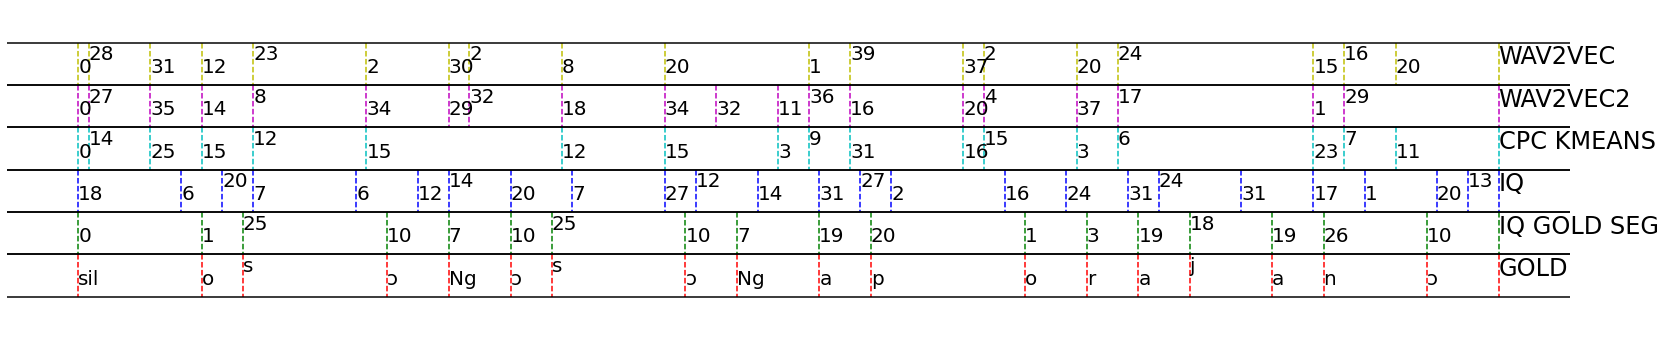

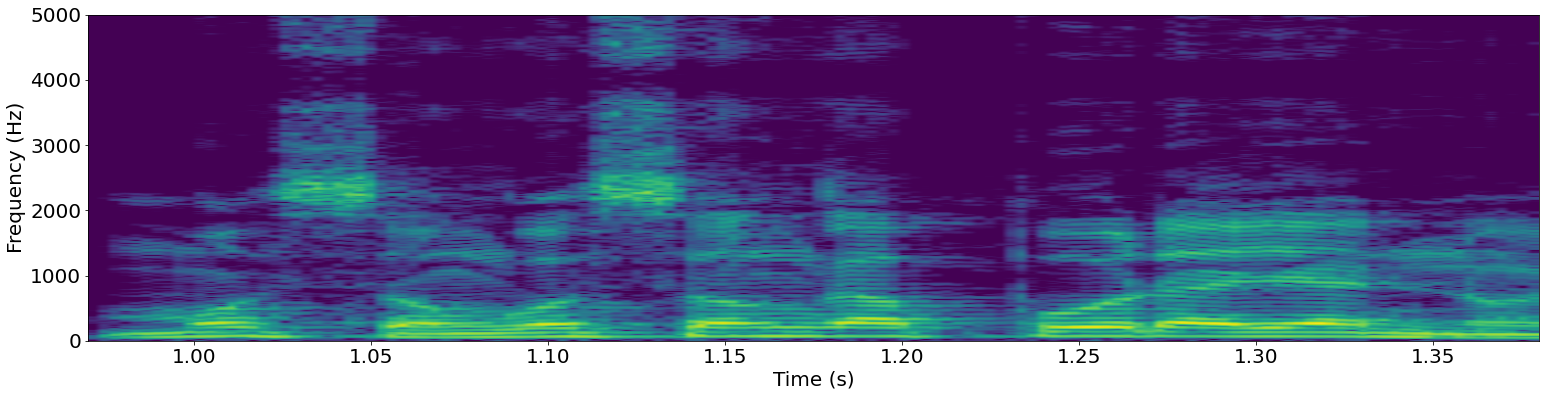

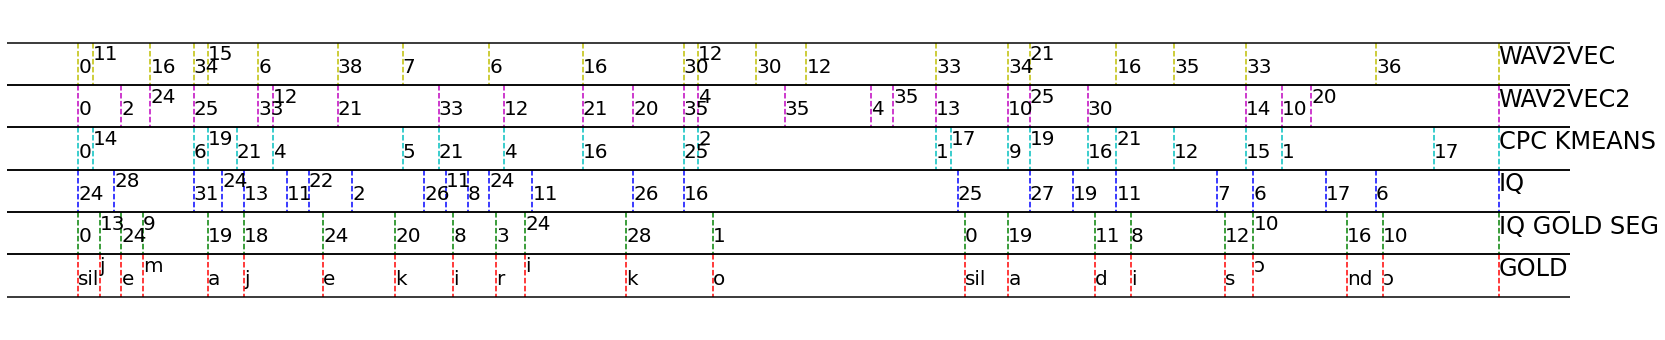

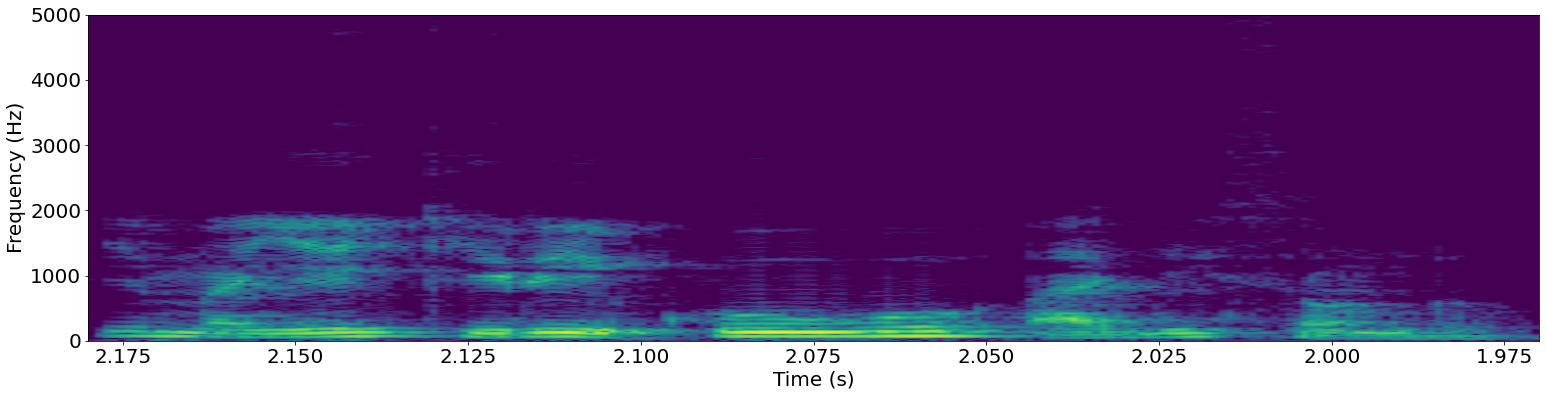

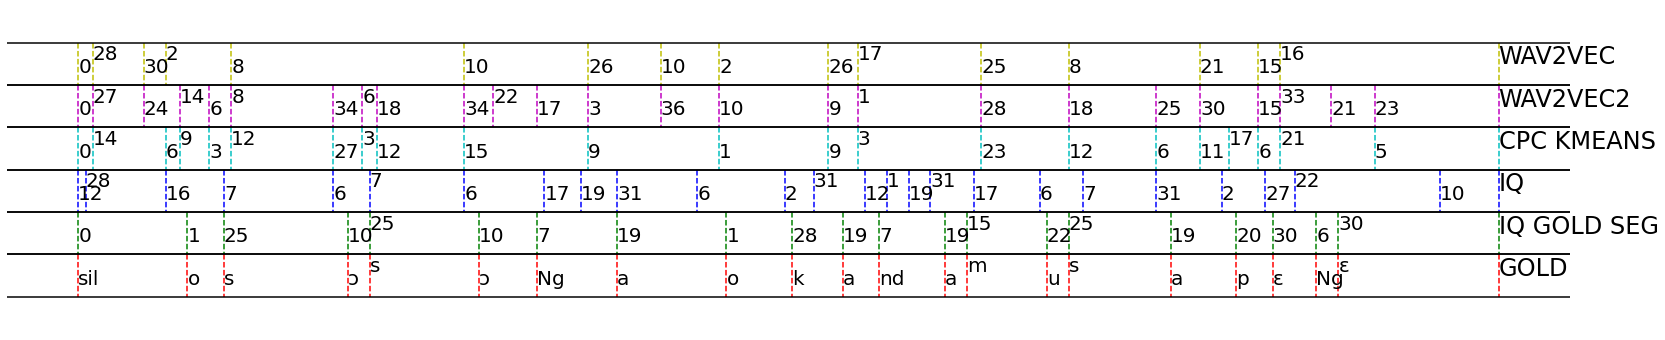

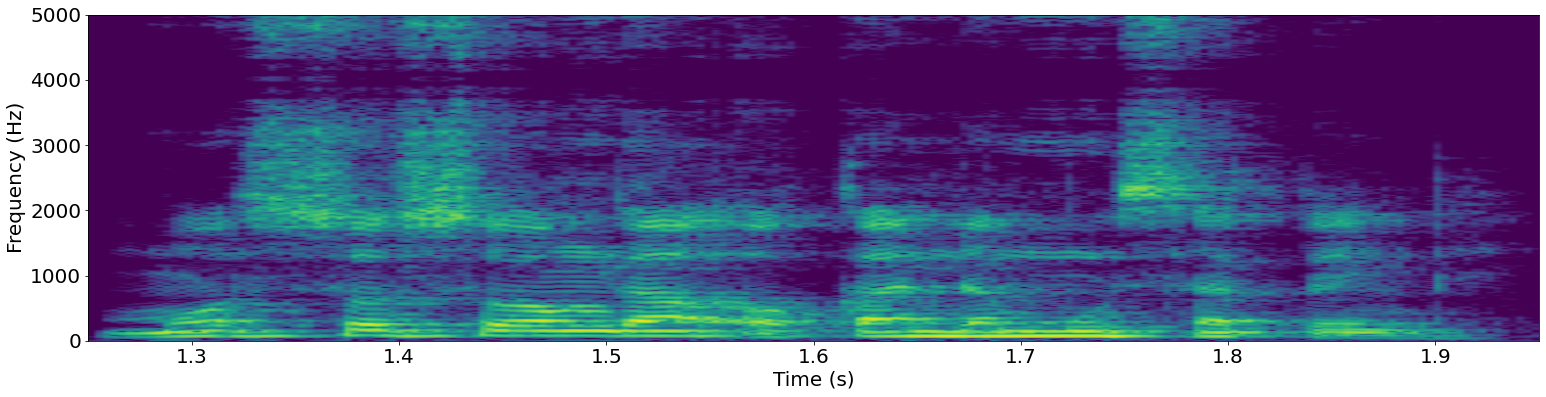

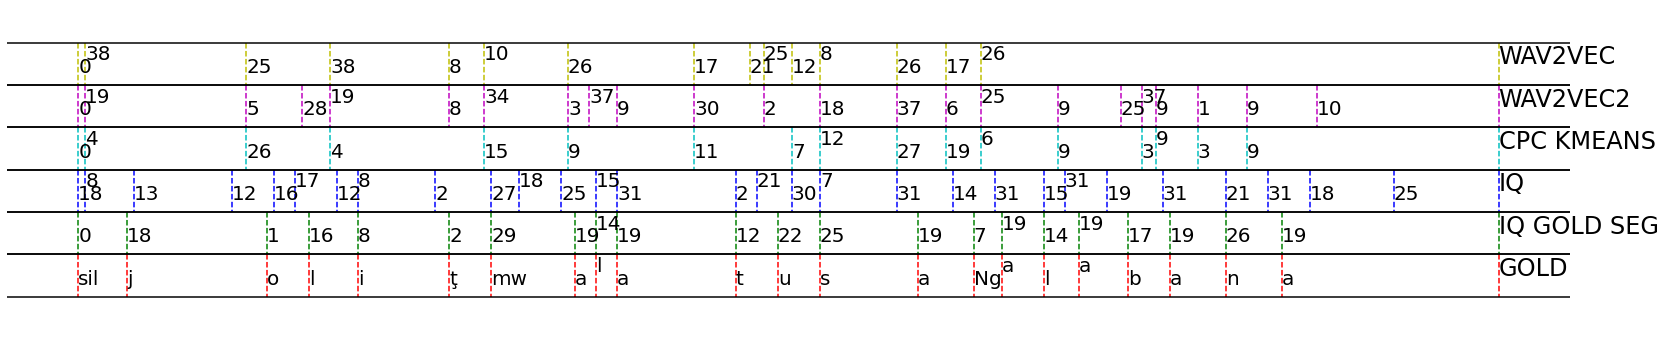

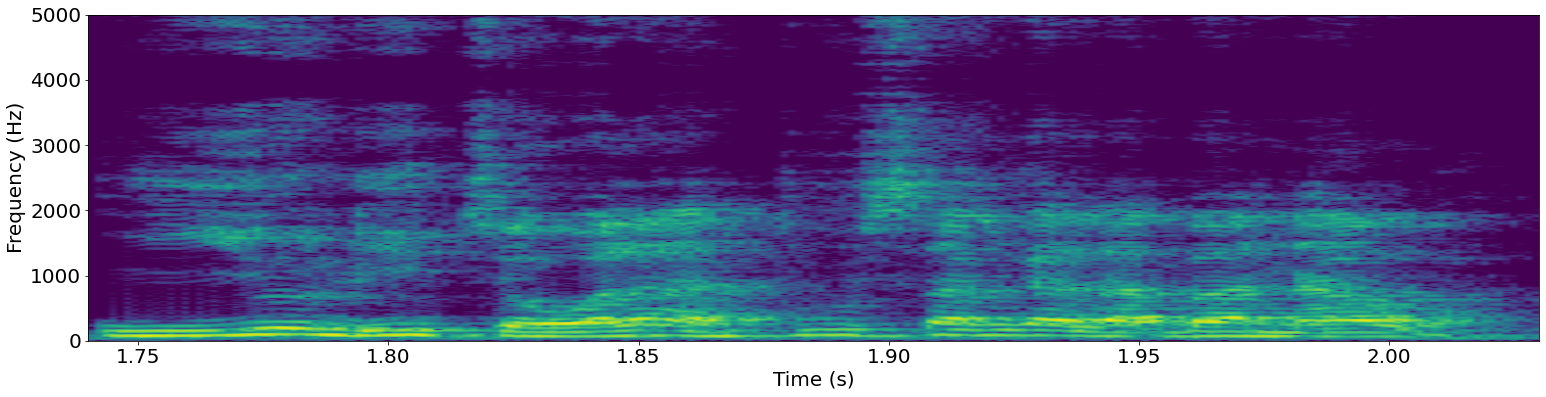

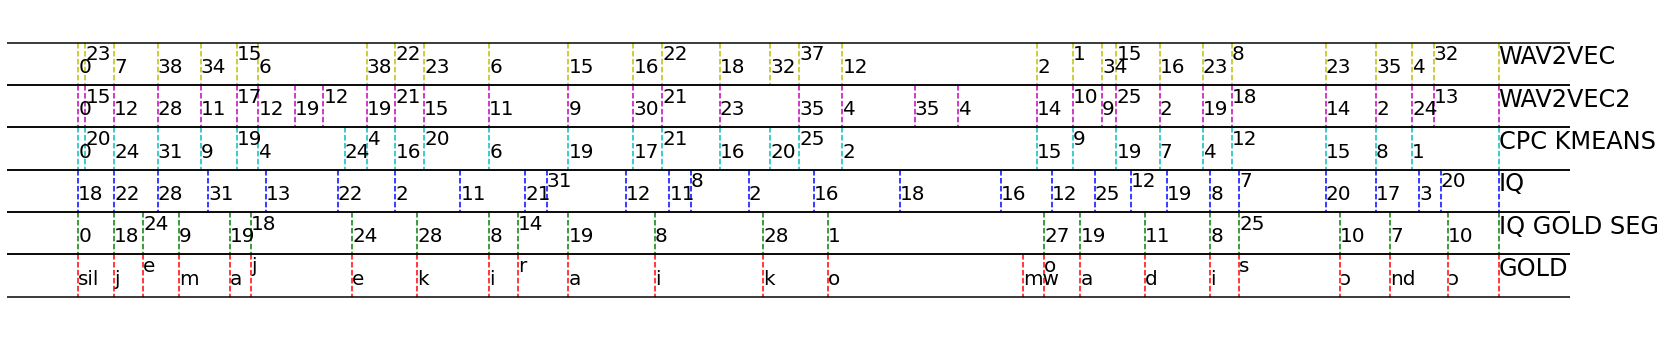

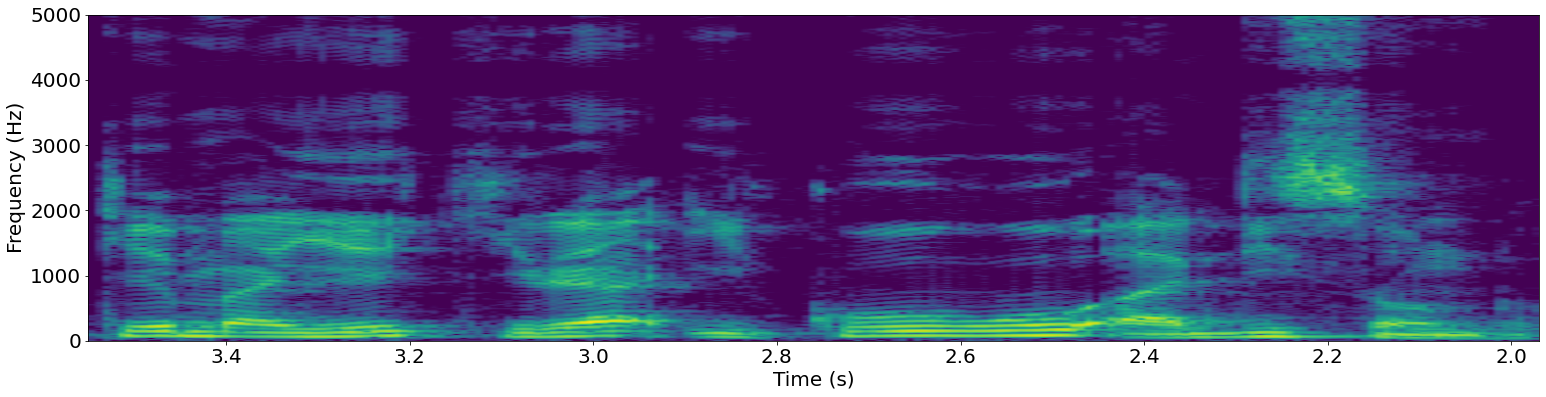

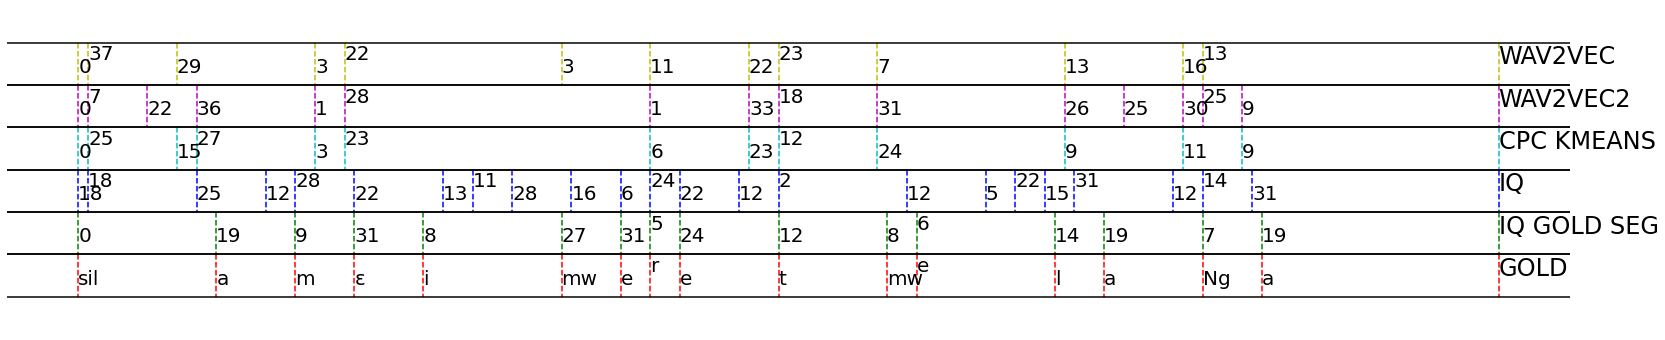

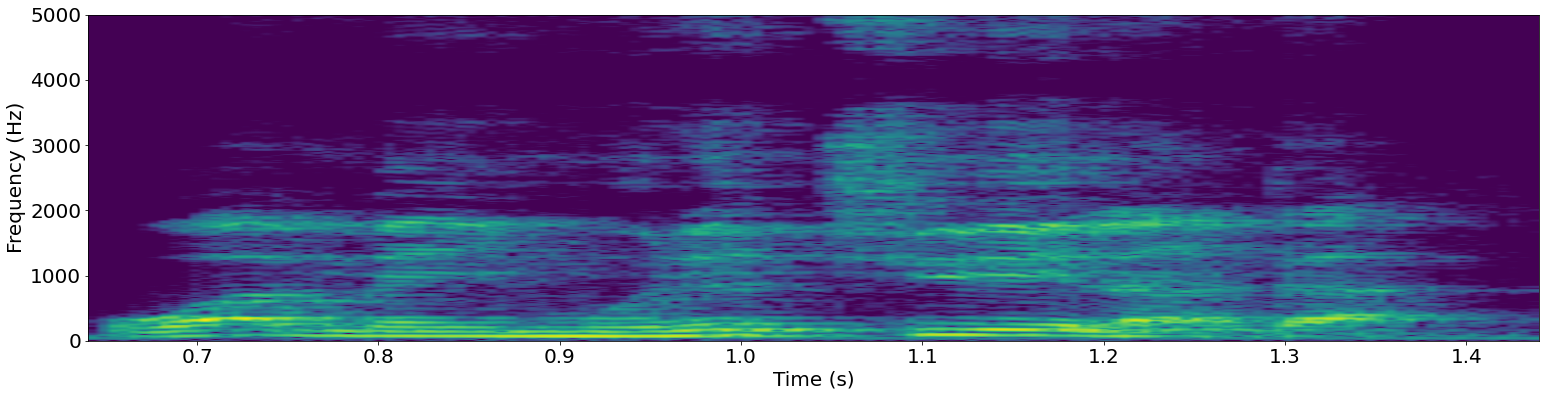

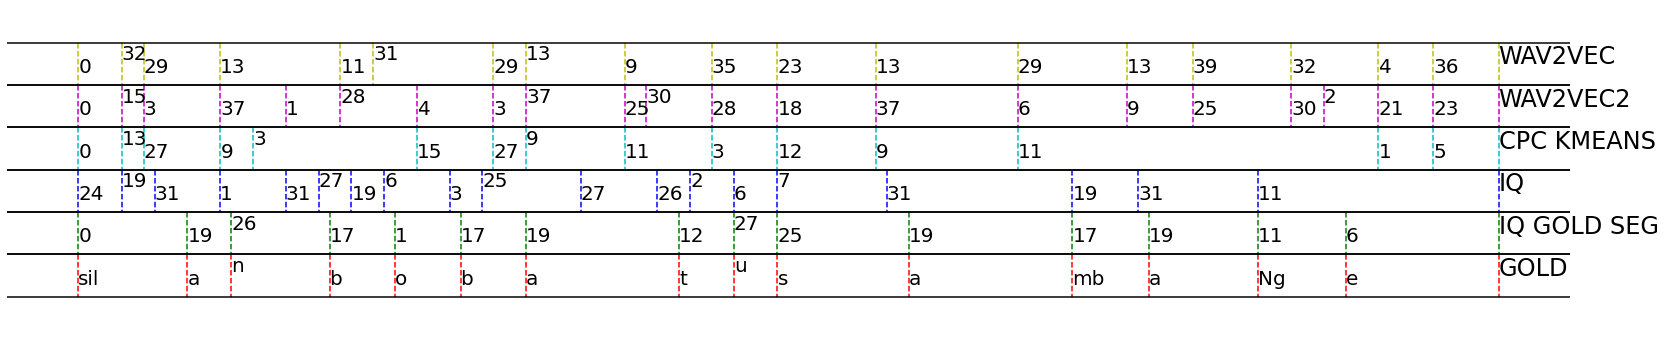

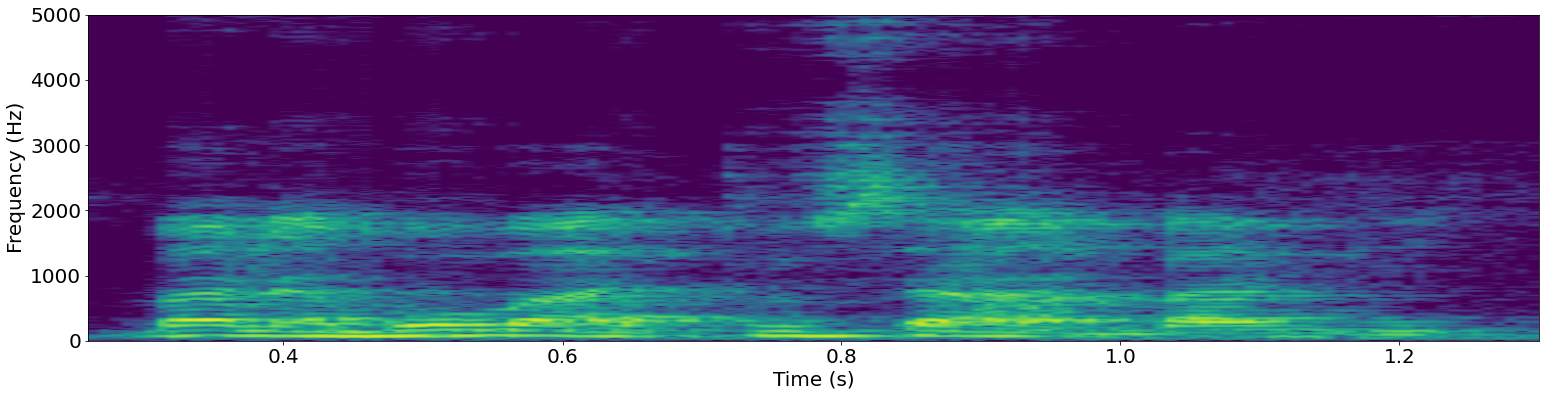

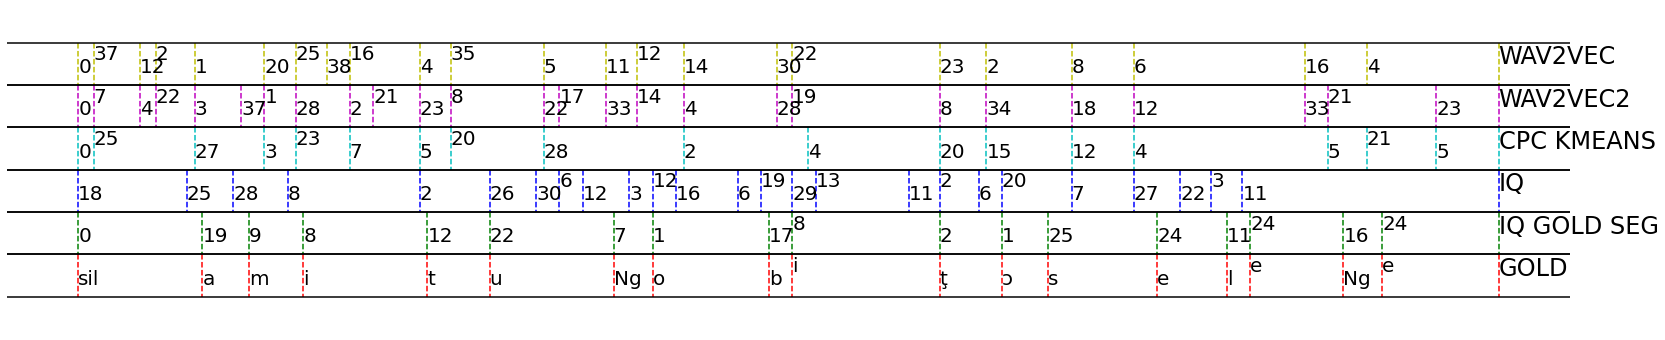

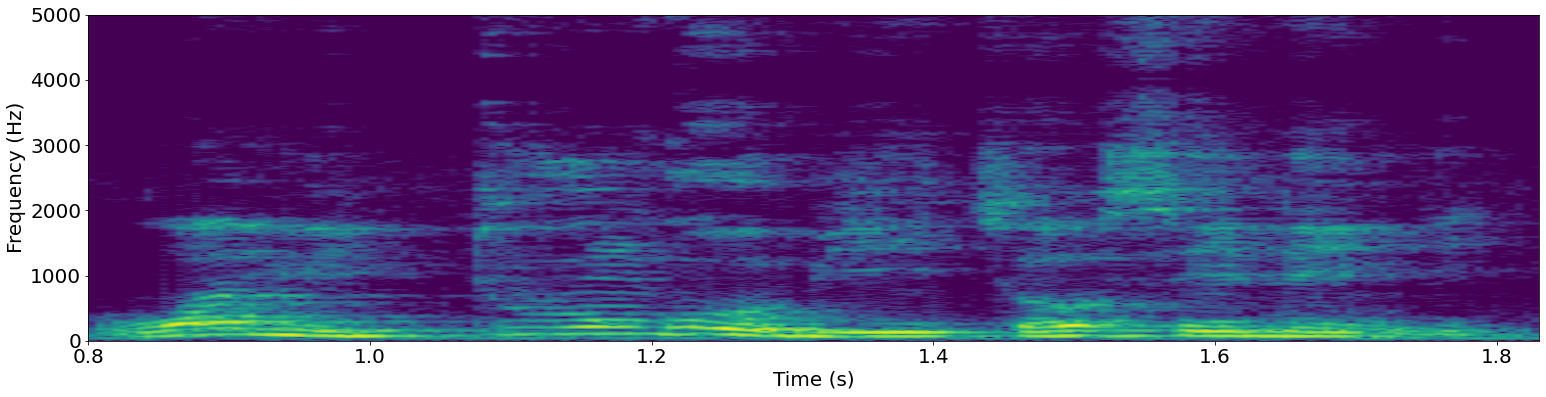

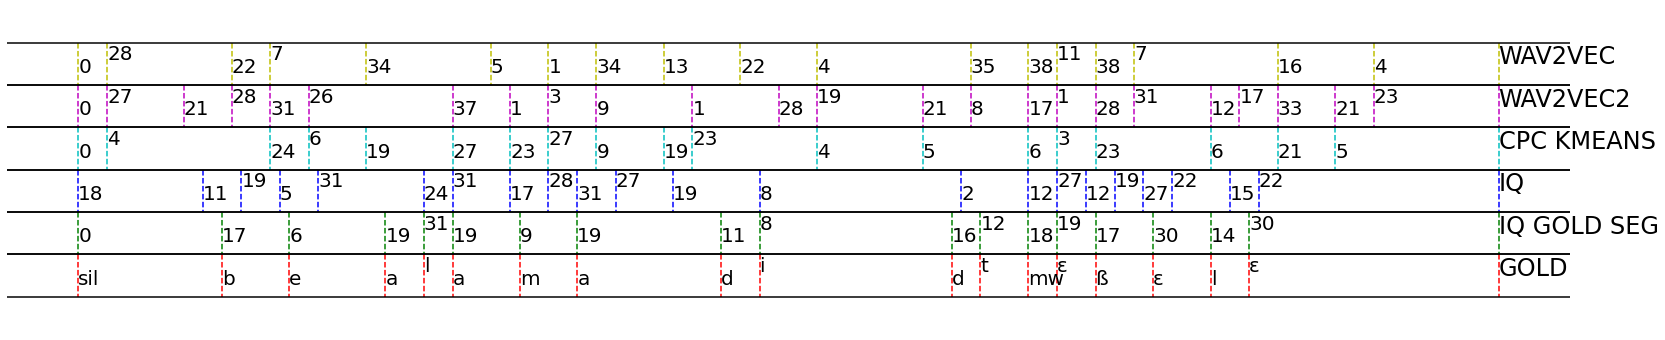

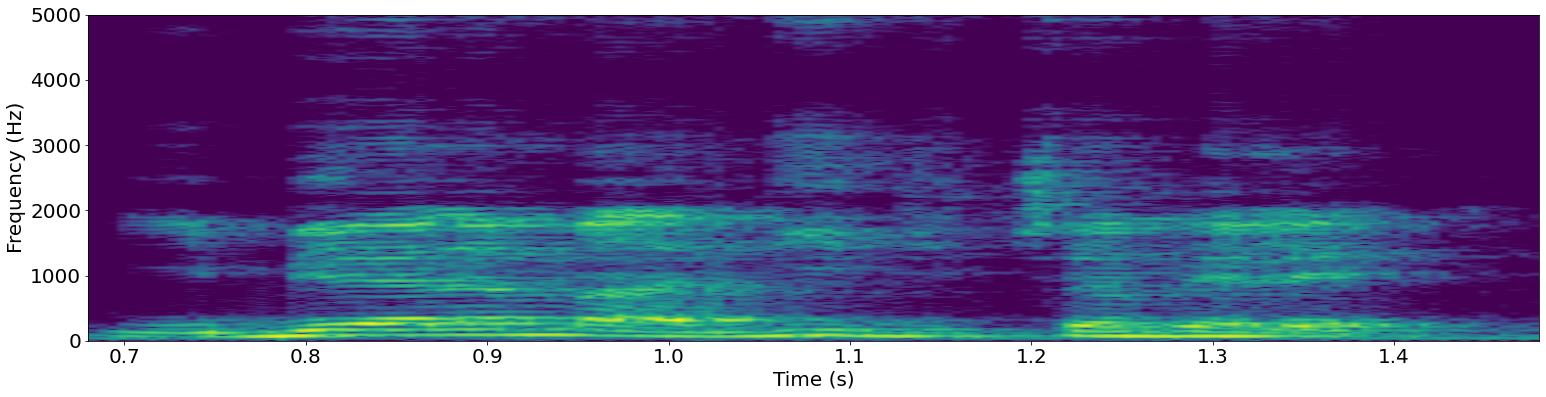

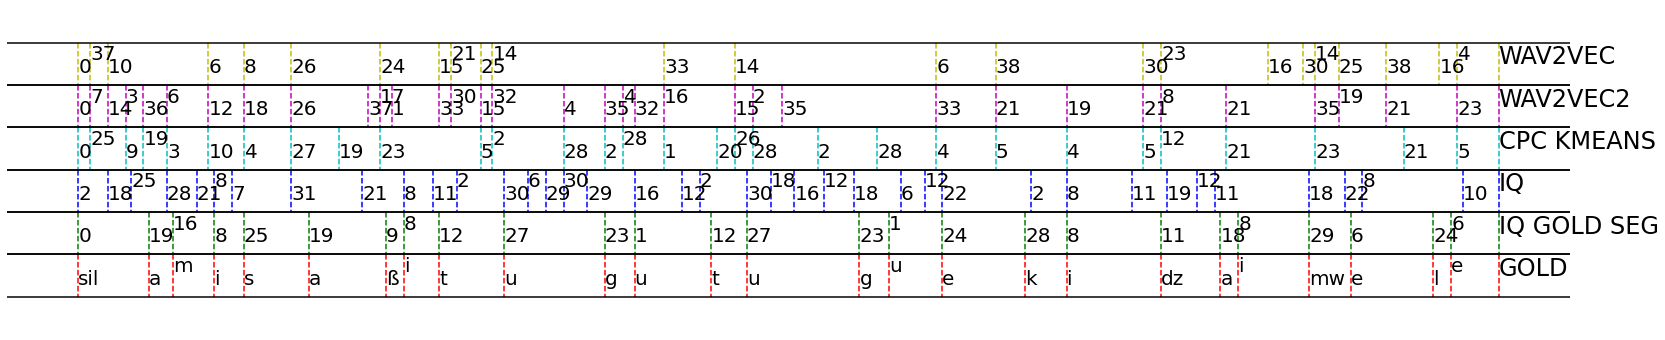

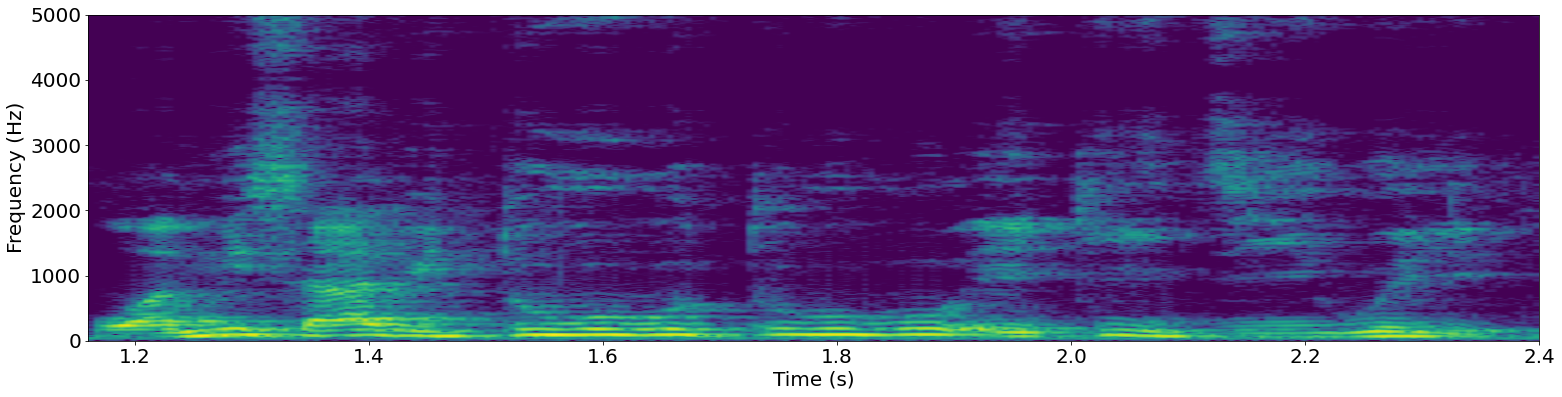

In [271]:
wav_root = '/ws/ifp-53_2/hasegawa/lwang114/data/mboshi-french-parallel-corpus/full_corpus_newsplit/all'
root = '/ws/ifp-53_2/hasegawa/lwang114/spring2021/DiscoPhoneInfoBottleneck/VIB-pytorch/checkpoints/textgrids_mboshi'
segment_dirs = ['gold', 'iq_gold_seg', 'iq', 'cpc_kmeans', 'wav2vec2', 'wav2vec']
audio_ids = [fn.split('.')[0] for fn in os.listdir(os.path.join(root, 'cpc_kmeans'))]

for audio_id in audio_ids:
    gold_path = os.path.join(root, segment_dirs[0], audio_id+'.TextGrid')
    segment_paths = [os.path.join(root, segment_dir, audio_id+'.TextGrid') for segment_dir in segment_dirs[1:]]
    wav_path = os.path.join(wav_root, audio_id+'.wav')
    out_path = f'/ws/ifp-53_2/hasegawa/lwang114/spring2021/DiscoPhoneInfoBottleneck/VIB-pytorch/checkpoints/mboshi_segmentation_plots/{audio_id}'

    plot_segmentation(gold_path, segment_paths, wav_path, out_path)